## Light Echo and Star Detection

In this tutorial, we will use the VGG16 AI model to detect light echoes and stars in images. We will train the model on a sample dataset and explore how the model makes predictions by analyzing the feature maps.

Exercises

- Load the [Dataset](#Dataset)

- Train the [Model](#Model)

- Make predictions and evaulation

- Saliency map

- Explore the [feature maps](#Feature-maps)

- tSNE scatter plot in feature space

In [1]:
from google.colab import drive
drive.mount('/drive', force_remount=True)


Mounted at /drive


In [2]:
cd '/drive/MyDrive/ztf_summer_school_2025/day4/le_study/'

/drive/MyDrive/Research/ztf_summer_school_2024/lectures/04-le


In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms, datasets
from torchsummary import summary

from sklearn.manifold import TSNE


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### dataset


In [5]:
image_trans = transforms.Compose([transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

image_dataset = datasets.ImageFolder(root='./dataset/vgg/train1/', transform=image_trans)
dataloader = DataLoader(image_dataset, batch_size=4, shuffle=True, num_workers=2)

image_dataset_test = datasets.ImageFolder(root='./dataset/vgg/test1/', transform=image_trans)
dataloader_test = DataLoader(image_dataset_test, batch_size=4, shuffle=True, num_workers=2)


In [6]:
image_dataset.classes
#image_dataset.__dict__

['LE', 'star']

In [7]:
images, labels = next( iter(dataloader) )

In [8]:
images.shape, labels.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

In [ ]:
labels

tensor([0, 1, 1, 0])

In [9]:
def plot_batch(images, labels):
    fig, axs = plt.subplots(1, 4, figsize=(8, 5), sharey=True)
    axs = axs.flatten()

    for i in range(4):
        axs[i].imshow(images[i, 0, :, :], origin='lower', cmap='gray', interpolation=None);
        axs[i].set_title(f'label={labels[i]}')
    return fig


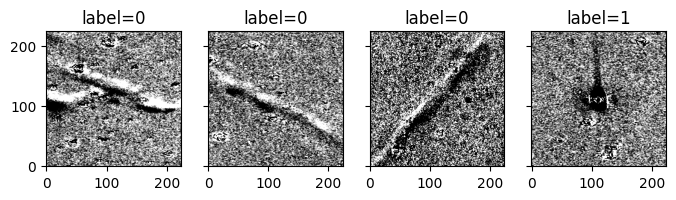

In [10]:
plot_batch(images, labels);

### train the model

Exercise: load the pre-trained vgg16 model, and train on the dataset

In [11]:
# Load the pre-trained VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.2MB/s]


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
# modify the last layer in classifier to match number of classes, 2 for our case

model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

In [13]:
model = model.to(device)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [15]:
# train the model
num_epochs = 20

loss_run = []

model.train()
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # input shape [4 batchsize, 3, 224, 224], labels shape [4]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_run.append(loss.item())
        print(f'epoch {epoch}, loss {loss.item()}')


epoch 0, loss 0.5013318657875061
epoch 0, loss 0.676638126373291
epoch 1, loss 0.5047848224639893
epoch 1, loss 0.7092954516410828
epoch 2, loss 0.5159927606582642
epoch 2, loss 0.4335567355155945
epoch 3, loss 0.5749489068984985
epoch 3, loss 0.2927929759025574
epoch 4, loss 0.6017972230911255
epoch 4, loss 0.2866171598434448
epoch 5, loss 0.3492605686187744
epoch 5, loss 0.4862533211708069
epoch 6, loss 0.32013756036758423
epoch 6, loss 0.3085041642189026
epoch 7, loss 0.24601703882217407
epoch 7, loss 0.17616486549377441
epoch 8, loss 0.1186475157737732
epoch 8, loss 0.15006983280181885
epoch 9, loss 0.13400736451148987
epoch 9, loss 0.09299266338348389
epoch 10, loss 0.15420518815517426
epoch 10, loss 0.062469664961099625
epoch 11, loss 0.028073446825146675
epoch 11, loss 0.10600975155830383
epoch 12, loss 0.06773713231086731
epoch 12, loss 0.07273343950510025
epoch 13, loss 0.022398050874471664
epoch 13, loss 0.020727984607219696
epoch 14, loss 0.013640055432915688
epoch 14, loss 

Text(0, 0.5, 'loss')

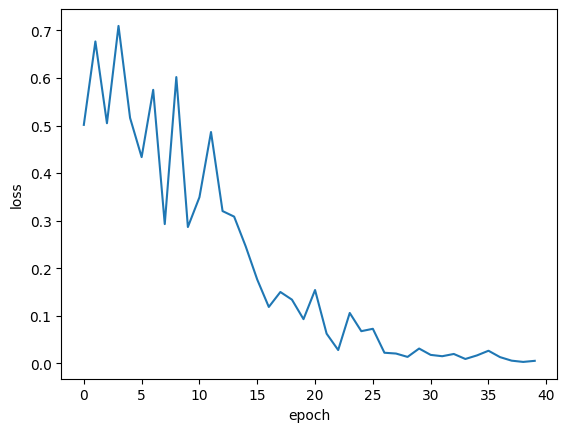

In [16]:
plt.plot(loss_run)
plt.xlabel('epoch')
plt.ylabel('loss')

### make prediction

In [17]:
images, labels = next(iter(dataloader_test))


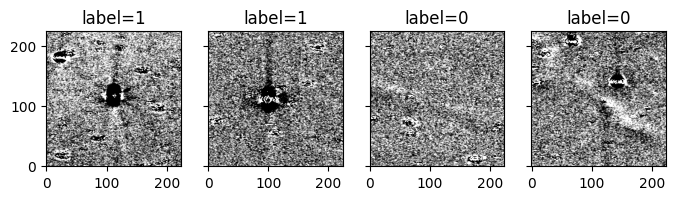

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(8, 5), sharey=True)
axs = axs.flatten()

for i in range(4):
    axs[i].imshow(images[i, 0, :, :], origin='lower', cmap='gray', interpolation=None);
    axs[i].set_title(f'label={labels[i]}')

In [19]:
model.eval();

In [20]:
images = images.to(device)

In [21]:
outputs = model(images).softmax(dim=1)
outputs

tensor([[0.0132, 0.9868],
        [0.0171, 0.9829],
        [0.9757, 0.0243],
        [0.4988, 0.5012]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [22]:
_, preds = torch.max(outputs, 1)
preds

tensor([1, 1, 0, 1], device='cuda:0')

In [ ]:
labels

tensor([0, 1, 0, 0])

Exercise: calculate the accuracy on training and test set


In [ ]:
#

Exercise: run a sliding window detection on larger images in folder rcnn/tiles/, generate a heatmap for the class output

In [ ]:
#

### saliency map

A saliency map is a visualization technique used in deep learning and computer vision to highlight the regions of an image that are most important for a model's predictions. It shows which parts of the input image have the greatest influence on the output of the model.

Saliency maps often use gradients to determine the importance of each pixel. The gradients of the output class score with respect to the input image are computed. These gradients indicate how much a small change in each pixel value would affect the class score.


initial with input data


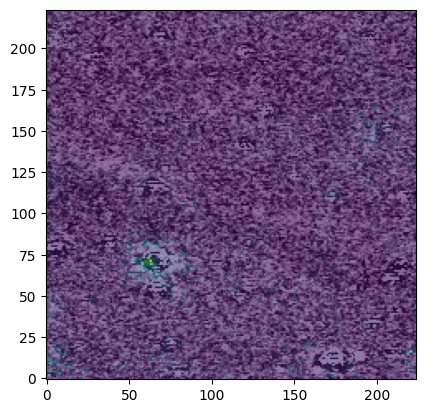

In [23]:
# create an image that requires_grad
input_image = torch.randn((1, 3, 224, 224), requires_grad=True, device=device)

img_idx = 2
# use one of image as input
input_data = images[img_idx].data
if input_data!=None:
    print('initial with input data')
    input_image.data = input_data.to(device).unsqueeze(0)

target_class = 0
output = model(input_image)
score = output[0, target_class]
model.zero_grad()
score.backward(retain_graph=True)
saliency, _ = torch.max(input_image.grad.data.abs(), dim=1)
saliency = saliency.squeeze().cpu().numpy()

plt.imshow(images.cpu()[img_idx, 0, :, :], origin='lower', cmap='gray');
plt.imshow(saliency, origin='lower', alpha=0.6);

### Explore features


The method of visualizing feature maps by optimizing the input image involves generating an image that maximizes the activation of a specific layer or neuron within a neural network. This technique helps us understand what patterns or features a particular part of the network is sensitive to.

Steps

- Select a target layer
- Use the forward hook to capture activations
- Initial a random image that require grads
- Adjust the input image in the direction of the gradients using an optimizer
- Visualize the optimized image

In [24]:
summary(model, (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

In [25]:
# Select a layer

layer_idx = 23

model.features[layer_idx]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [26]:
def get_layer_output(model, input_image, layer_index=29,):
    """get the output from a layer
    input_image: shape [batch, 3, 244, 244]"""

    input_image = input_image.to(device)
    # Dictionary to store the output from the specified layer
    outputs = {}

    def hook_fn(module, input, output):
        """register to layer, run during forward"""
        outputs["layer_output"] = output

    # Register the hook
    hook = model.features[layer_index].register_forward_hook(hook_fn)

    _ = model(input_image)  # Forward pass to get the activations

    # Remove the hook after optimization
    hook.remove()

    layer_output = outputs["layer_output"].detach().cpu().numpy()
    return layer_output

In [27]:
def get_featuremap(model=model,
                   input_data=None,
                   layer_index=29, feature_map_index=0, num_iterations = 100, lr=0.01):
    """optimize an random input for a specific layer to get the high activations,
    """

    # Step 1: Create a random image
    # Initialize a random image tensor with required shape and allow gradient computation
    input_image = torch.randn((1, 3, 224, 224), requires_grad=True, device=device)

    if input_data!=None:
        print('initial with input data')
        input_image.data = input_data.to(device).unsqueeze(0)

    # Step 2: Load the pre-trained VGG16 model in evaluation mode

    # Step 3: Register a forward hook to access the features of a specific layer (e.g., layer 10)
    #layer_index = 29
    #feature_map_index = 12  # Specify the feature map index you want to maximize

    # Dictionary to store the output from the specified layer
    outputs = {}

    def hook_fn(module, input, output):
        """register to layer, run during forward"""
        outputs["layer_output"] = output

    # Register the hook
    hook = model.features[layer_index].register_forward_hook(hook_fn)

    # Step 4: Define the optimizer and the loss function
    # Use an optimizer to change the pixel values of the input image
    optimizer = torch.optim.Adam([input_image], lr=lr)

    # Number of iterations for optimization
    #num_iterations = 100

    # Optimization loop
    for i in range(num_iterations):
        optimizer.zero_grad()  # Clear previous gradients

        _ = model(input_image)  # Forward pass to get the activations

        # Get the activation of the specific feature map
        layer_output = outputs["layer_output"]
        feature_map_activation = layer_output[0, feature_map_index]  # Accessing the desired feature map

        # Calculate the mean activation of the feature map
        loss = - torch.mean(feature_map_activation) # Negate to maximize

        # Perform backpropagation and optimize the image
        loss.backward()
        optimizer.step()

        #print('grad', type(input_image.grad))

        # Clip the values of the image tensor to keep them in the valid range
        with torch.no_grad():
            input_image.clamp_(0, 1)

        if i % 10 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    # Remove the hook after optimization
    hook.remove()

    # Step 5: Display the optimized image
    # Convert the optimized image tensor to a format suitable for displaying
    optimized_image = input_image.detach().cpu().squeeze()  # Remove batch dimension and move to CPU
    optimized_image = optimized_image.permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
    optimized_image = optimized_image.numpy()
    return optimized_image, input_image


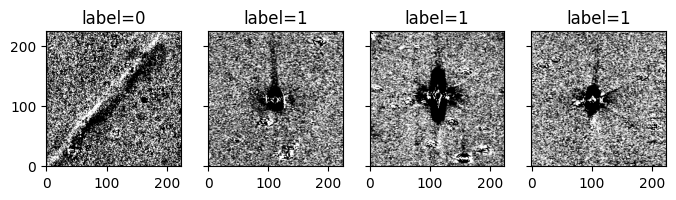

In [28]:
img, labels = next(iter(dataloader))

plot_batch(img, labels);

In [29]:
layer_output = get_layer_output(model, img, layer_index=29)
layer_output.shape

(4, 512, 14, 14)

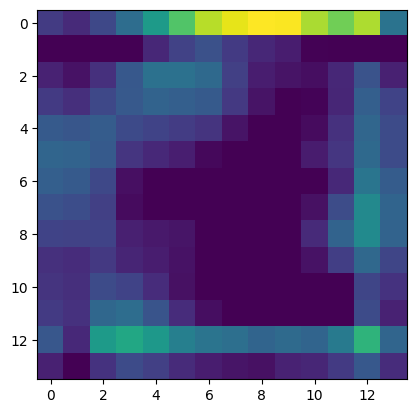

In [34]:
plt.imshow(layer_output[0, 20, :, :],)

In [35]:
layer_output_mean = layer_output.mean(axis=3).mean(axis=2)

In [36]:
layer_output_mean.shape

(4, 512)

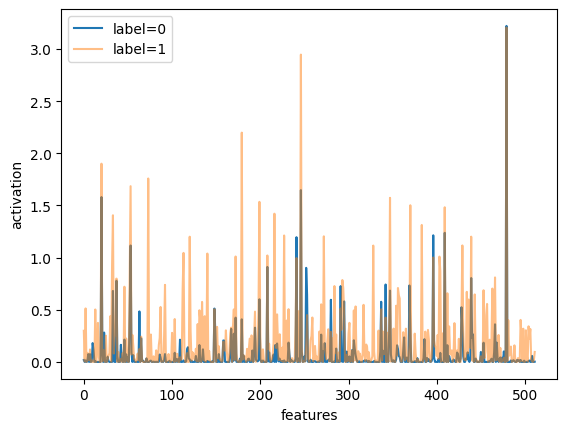

In [37]:
# activation values in feature space
plt.plot(layer_output_mean[0], label=f'label={labels.numpy()[0]}')
#plt.plot(layer_output_mean[1], alpha=0.5,)
#plt.plot(layer_output_mean[2], alpha=0.5)
plt.plot(layer_output_mean[3], alpha=0.5, label=f'label={labels.numpy()[3]}')

plt.xlabel('features')
plt.ylabel('activation')

plt.legend()

In [38]:
np.argsort(layer_output_mean[1])[::-1][:5]

array([246, 479,  20, 179, 199])

In [39]:
np.argsort(layer_output_mean[0])[::-1][:5]

array([479, 246,  20, 409, 396])

In [40]:
layer_output_mean[0] [ np.argsort(layer_output_mean[0])[::-1][:5] ]

array([3.221925 , 1.6474237, 1.5808738, 1.2380139, 1.2140888],
      dtype=float32)

In [41]:
fmaps = {}
feature_list = [119,  65, 246, 385, 172]
for i in feature_list:
    #idx = 303
    optimized_image, input_image = get_featuremap(model=model,
                                     #input_data=img[0].data,
                                     layer_index=layer_idx, feature_map_index=i,
                                     num_iterations=300, lr=0.05)
    fmaps[i] = optimized_image

Iteration 0, Loss: -0.05492757260799408
Iteration 10, Loss: -7.415998458862305
Iteration 20, Loss: -24.325435638427734
Iteration 30, Loss: -43.1746826171875
Iteration 40, Loss: -58.734004974365234
Iteration 50, Loss: -70.60709381103516
Iteration 60, Loss: -79.49224090576172
Iteration 70, Loss: -86.48373413085938
Iteration 80, Loss: -92.01565551757812
Iteration 90, Loss: -96.43418884277344
Iteration 100, Loss: -99.78551483154297
Iteration 110, Loss: -102.43314361572266
Iteration 120, Loss: -104.63249206542969
Iteration 130, Loss: -106.44892120361328
Iteration 140, Loss: -107.95905303955078
Iteration 150, Loss: -109.29107666015625
Iteration 160, Loss: -110.56344604492188
Iteration 170, Loss: -111.74591827392578
Iteration 180, Loss: -112.80570983886719
Iteration 190, Loss: -113.76114654541016
Iteration 200, Loss: -114.59326934814453
Iteration 210, Loss: -115.32929992675781
Iteration 220, Loss: -116.00469970703125
Iteration 230, Loss: -116.653564453125
Iteration 240, Loss: -117.29590606689

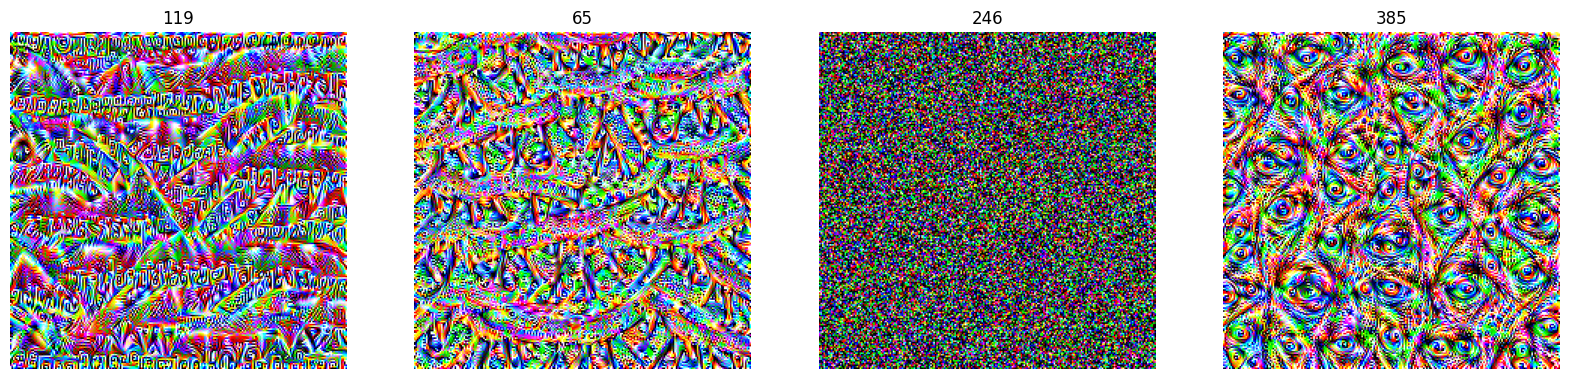

In [42]:

n = len(feature_list)
fig, axs = plt.subplots(1, n-1, figsize=(20, 5))

for i in range(n-1):
    axs[i].imshow(fmaps[ feature_list[i] ])
    axs[i].set_title(feature_list[i] )
    axs[i].axis('off')

Exercise: generate feature plots for several early and later layers in VGG16, how do stars and differ in feature space?

In [ ]:
#

#### TSNE
t-SNE is a dimensionality reduction technique used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. It is especially useful for exploring the high-dimensional datasets and understanding how data points relate to each other.



In [43]:
Colors = {0:'tab:red', 1:'tab:blue'}

In [ ]:
layer_output_mean.shape

(4, 512)

In [44]:
tsne = TSNE(n_components=2, random_state=0, perplexity=3)


In [45]:
tsne_results = tsne.fit_transform(layer_output_mean)


Text(0, 0.5, 'feature 2')

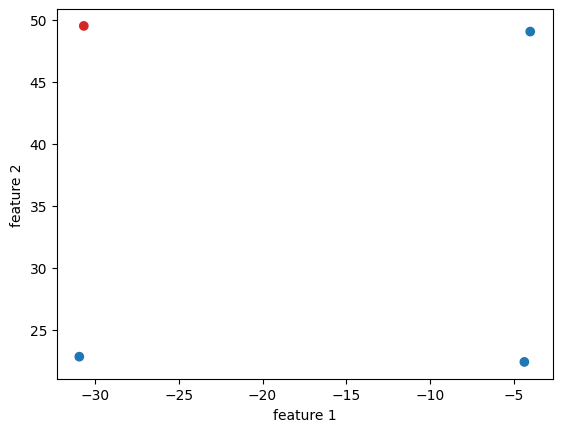

In [46]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            color=[Colors[i] for i in labels.numpy()])

plt.xlabel('feature 1')
plt.ylabel('feature 2')

Exercise: plot for all images in train and test sets, does this reveal any clustering patterns for LE and star images?

In [ ]:
#

Exercise: try another model from https://pytorch.org/vision/0.9/models.html, are there differences in features and performance?

In [ ]:
#